### Importing the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as to
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

import torch
import torchvision

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable

import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR

## Load Dataset

In [2]:
dataset = MNIST('data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('data', train=False, transform=ToTensor())

### Check Cuda Support

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Loader support Class

In [4]:
def comp( value ):    
    return value[0]

In [5]:
class SiamDataset(Dataset):
    
    def __init__(self, input_dataset):
        
        data = list()
        
        for i in range(len(input_dataset)):            
            data.append( [ [input_dataset[i][1]], input_dataset[i][0].numpy() ] )
        
        data.sort(key = comp)        
        self.len = len(input_dataset)        
        self.img = {}
        
        
        for i in data:
            
            if i[0][0] not in self.img :
                self.img[i[0][0]] = list()
                self.img[i[0][0]].append(i[1])
            
            else :
                self.img[i[0][0]].append(i[1])       
        
        pass
    
    
    def __getitem__(self, idx):
                
        clas = np.random.randint(0,10)
            
        length = len(self.img[clas])
        im1, im2 = np.random.randint(0,length,2)
            
        img1 = to.tensor(np.reshape(self.img[clas][im1],(1,28,28)), dtype=to.float32)
        img2 = to.tensor(np.reshape(self.img[clas][im2],(1,28,28)), dtype=to.float32)
        y1 = to.tensor(np.ones(1,dtype=np.float32),dtype=to.float32)
                           
        len1 = len(self.img[clas])
        clas2 = ( clas + np.random.randint(0,9) ) % 9
        len2 = len(self.img[clas2])
            
        im3 = np.random.randint(0,len1)
        im4 = np.random.randint(0,len2)
            
        img3 = to.tensor(np.reshape(self.img[clas][im3],(1,28,28)), dtype=to.float32)
        img4 = to.tensor(np.reshape(self.img[clas2][im4],(1,28,28)), dtype=to.float32)
        y2 = to.tensor(np.zeros(1,dtype=np.float32),dtype=to.float32)
            
        return  img1, img2, y1, img3, img4, y2
            
    def __len__(self):
        return 10000
            

### Get Data Loader

In [6]:
siamdset = SiamDataset(dataset)
train_dataloader = DataLoader(siamdset, shuffle=True, batch_size= 256)

siamdset = SiamDataset(test_dataset)
test_dataloader = DataLoader(siamdset, shuffle=True, batch_size= 1)

In [7]:
len(train_dataloader), len(test_dataset)

(40, 10000)

### Siamese Network

In [8]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese,self).__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.relu = nn.ReLU()
        
        self.fc = nn.Sequential(
            nn.Linear(20, 1),
            nn.Sigmoid()
        )
        
    def forward_once(self,x):
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x
    
    def forward(self, x, y, flag=False):    
                
        out1 = self.forward_once(x)
        out2 = self.forward_once(y)
        
        if flag:
            out = torch.cat((out1, out2), 1)
            out = self.fc(out)
            return out
        else:       
            return out1, out2    

### Constructive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [10]:
class TripletLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

### Training Function: ContrastiveLoss 

In [11]:
def train(model, Criterion, Optimizer, train_lodr, number_epochs=50, weights_path=""):
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in tqdm(range(0,number_epochs)):        

        ploss = 0 
        nloss = 0 
        
        for data in train_lodr:
    
            img1, img2 , label1, img3, img4, label2 = Variable(data[0].view(-1, 28*28)).to(device), Variable(data[1].view(-1, 28*28)).to(device), Variable(data[2]).to(device), Variable(data[3].view(-1, 28*28)).to(device), Variable(data[4].view(-1, 28*28)).to(device), Variable(data[5]).to(device)   

            
            Optimizer.zero_grad()
            
            output1,output2 = model(img1,img2)
            loss_pos = Criterion(output1,output2,label1)
            loss_pos.backward()
            
            Optimizer.step()

            Optimizer.zero_grad()
            
            output3,output4 = model(img3,img4)
            loss_neg = Criterion(output3,output4,label2)
            loss_neg.backward()
            
            Optimizer.step()
            
            ploss += loss_pos.item()
            nloss += loss_neg.item()
        
        counter.append(epoch+1)
        loss_history.append(((ploss+nloss)/len(train_lodr)))

        to.save(siam.state_dict(), weights_path)

    return counter, loss_history

### Training Function: TripletLoss 

In [12]:
def traintriplet(model, Criterion, Optimizer, train_lodr, number_epochs=50, weights_path=""):
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in tqdm(range(0,number_epochs)):        

        tloss = 0 
        
        for data in train_lodr:
    
            img1, img2 , _, img3, img4, _ = Variable(data[0].view(-1, 28*28)).to(device), Variable(data[1].view(-1, 28*28)).to(device), Variable(data[2]).to(device), Variable(data[3].view(-1, 28*28)).to(device), Variable(data[4].view(-1, 28*28)).to(device), Variable(data[5]).to(device)   

            
            Optimizer.zero_grad()
            
            output1,output2 = model(img1,img2)
            _, output4 = model(img1,img4)
            
            loss = Criterion(output1, output2, output4)
            loss.backward()
            
            Optimizer.step()
            
            tloss += loss.item()
        
        counter.append(epoch+1)
        loss_history.append((tloss/len(train_lodr)))
        
        to.save(siam.state_dict(), weights_path)

    return counter, loss_history

### Training Function: CrossEntropyLoss 

In [13]:
def traincrossetropy(model, Criterion, Optimizer, train_lodr, number_epochs=50, weights_path=""):
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in tqdm(range(0,number_epochs)):        

        ploss = 0 
        nloss = 0 
        
        for data in train_lodr:
    
            img1, img2 , label1, img3, img4, label2 = Variable(data[0].view(-1, 28*28)).to(device), Variable(data[1].view(-1, 28*28)).to(device), Variable(data[2]).to(device), Variable(data[3].view(-1, 28*28)).to(device), Variable(data[4].view(-1, 28*28)).to(device), Variable(data[5]).to(device)   

            
            Optimizer.zero_grad()
            
            output1 = model(img1,img2, flag=True)
            loss_pos = Criterion(output1,label1)
            loss_pos.backward()
            
            Optimizer.step()

            Optimizer.zero_grad()
            
            output2 = model(img3,img4, flag=True)
            loss_neg = Criterion(output2,label2)
            loss_neg.backward()
            
            Optimizer.step()
            
            ploss += loss_pos.item()
            nloss += loss_neg.item()
        
        counter.append(epoch+1)
        loss_history.append(((ploss+nloss)/len(train_lodr)))

        to.save(siam.state_dict(), weights_path)

    return counter, loss_history

### Testing Funtion

In [14]:
def evaluation(model, Criterion, Optimizer, test_lodr, weights_path=""):
    
    total = 0
    correct = 0

    model.load_state_dict(torch.load(weights_path))
    
    def oneshot(model,img1,img2):
        with torch.no_grad():
            output1,output2 = model(img1,img2)

        euclidean_distance = F.pairwise_distance(output1, output2)            
        if euclidean_distance > 0.5:
            return 1
        else:
            return 0
    
    for data in tqdm(test_lodr):

        img1, img2 , label1, img3, img4, label2 = Variable(data[0].view(-1, 28*28)).to(device), Variable(data[1].view(-1, 28*28)).to(device), data[2], Variable(data[3].view(-1, 28*28)).to(device), Variable(data[4].view(-1, 28*28)).to(device), data[5]   
        
        total += 1
        if label1[0][0].item() == oneshot(model, img1, img2):
            correct += 1
        
        if label2[0][0].item() == oneshot(model, img3, img4):
            correct += 1        

    return ((correct/total)*100)

### Plot

In [15]:
epochs = 15
def plotlossgraph(x, y, title=""):
    plt.plot(x, y, 'g', label='Training loss')

    plt.title(title+' Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    
xepoch = range(1,epochs+1)

### Make network Object

In [16]:
siam = Siamese().to(device)
siam

Siamese(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (fc): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Hyper Perametes experiment 1

## ContrastiveLoss

## Question ContrastiveLoss
### RMSprop

### Defining loss & optimizer Function

In [17]:
siam = Siamese().to(device)

Criterion = ContrastiveLoss().to(device)
Optimizer = optim.RMSprop(siam.parameters(), lr=0.001, momentum=0.9)

### Train

In [18]:
counter, loss_history = train(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./RMSprop1_c.pth")

100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


In [19]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./RMSprop1_c.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1017.53it/s]


98.13

### Graph Plot

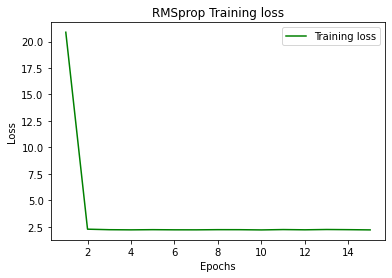

In [20]:
plotlossgraph(counter, loss_history, title="RMSprop")

## Question ContrastiveLoss
### Adam

### Defining loss & optimizer Function

In [21]:
siam = Siamese().to(device)

Criterion = ContrastiveLoss().to(device)
Optimizer = optim.Adam(siam.parameters(), lr=0.001)

### Train

In [22]:
counter, loss_history = train(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./Adam1_c.pth")

100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


In [23]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./Adam1_c.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1088.63it/s]


98.98

### Graph Plot

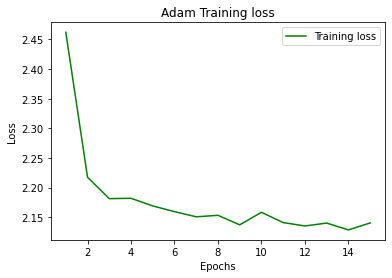

In [24]:
plotlossgraph(counter, loss_history, title="Adam")

## Question ContrastiveLoss
### Mini Batch gradient decent

### Defining loss & optimizer Function

In [25]:
siam = Siamese().to(device)

Criterion = ContrastiveLoss().to(device)
Optimizer = optim.SGD(siam.parameters(), lr=0.001, momentum=0.9)

### Train

In [26]:
counter, loss_history = train(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./SGD1_c.pth")

100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


In [27]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./SGD1_c.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1106.83it/s]


97.3

### Graph Plot

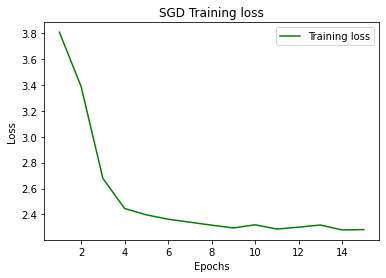

In [28]:
plotlossgraph(counter, loss_history, title="SGD")

## TripletMarginLoss

## Question TripletMarginLoss
### RMSprop

### Defining loss & optimizer Function

In [29]:
siam = Siamese().to(device)

Criterion = nn.TripletMarginLoss(margin=2.0).to(device)
Optimizer = optim.RMSprop(siam.parameters(), lr=0.001, momentum=0.9)

### Train

In [30]:
counter, loss_history = traintriplet(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./RMSprop1_t.pth")

100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


In [31]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./RMSprop1_t.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1082.21it/s]


99.1

### Graph Plot

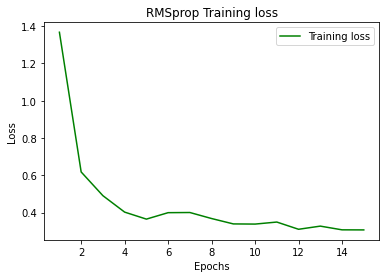

In [32]:
plotlossgraph(counter, loss_history, title="RMSprop")

## Question TripletMarginLoss
### Adam

### Defining loss & optimizer Function

In [33]:
siam = Siamese().to(device)

Criterion = nn.TripletMarginLoss(margin=2.0).to(device)
Optimizer = optim.Adam(siam.parameters(), lr=0.001)

### Train

In [34]:
counter, loss_history = traintriplet(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./Adam1_t.pth")

100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


In [35]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./Adam1_t.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1052.10it/s]


97.54

### Graph Plot

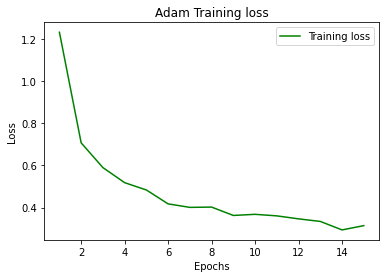

In [36]:
plotlossgraph(counter, loss_history, title="Adam")

## CrossEntropyLoss

## Question CrossEntropyLoss
### RMSprop

### Defining loss & optimizer Function

In [37]:
siam = Siamese().to(device)

Criterion = nn.BCELoss().to(device)
Optimizer = optim.RMSprop(siam.parameters(), lr=0.001, momentum=0.9)

### Train

In [38]:
counter, loss_history = traincrossetropy(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./RMSprop1_e.pth")

100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


In [39]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./RMSprop1_e.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1052.91it/s]


99.29

### Graph Plot

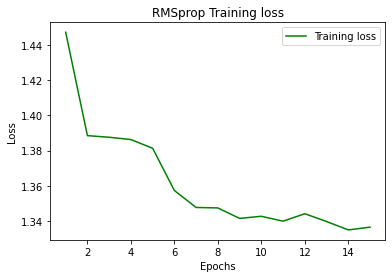

In [40]:
plotlossgraph(counter, loss_history, title="RMSprop")

## Question CrossEntropyLoss
### Adam

### Defining loss & optimizer Function

In [41]:
siam = Siamese().to(device)

Criterion = nn.BCELoss().to(device)
Optimizer = optim.Adam(siam.parameters(), lr=0.001)

### Train

In [42]:
counter, loss_history = traincrossetropy(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./Adam1_e.pth")

100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


In [43]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./Adam1_e.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1070.78it/s]


99.61

### Graph Plot

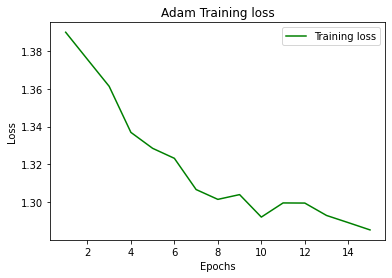

In [44]:
plotlossgraph(counter, loss_history, title="Adam")

## Question CrossEntropyLoss
### Mini Batch gradient decent

### Defining loss & optimizer Function

In [45]:
siam = Siamese().to(device)

Criterion = nn.BCELoss().to(device)
Optimizer = optim.SGD(siam.parameters(), lr=0.001, momentum=0.9)

### Train

In [46]:
counter, loss_history = traincrossetropy(siam, Criterion, Optimizer, train_dataloader, number_epochs=epochs, weights_path="./SGD1_e.pth")

100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


In [49]:
acc = evaluation(siam, Criterion, Optimizer, test_dataloader, weights_path="./SGD1_c.pth")
acc

100%|██████████| 10000/10000 [00:09<00:00, 1045.54it/s]


97.22

### Graph Plot

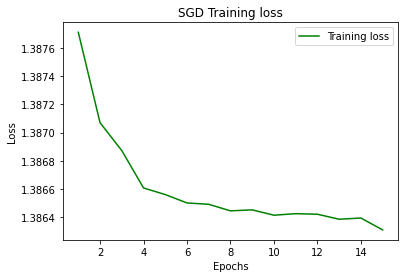

In [50]:
plotlossgraph(counter, loss_history, title="SGD")

## Mention Pros and Cons of Siamese Networks .

### pors

- More Robust to class Imbalance
    - Because of One-shot learning, few images per class is sufficient for training
- Nice to an ensemble with the best classifier
    - Given that its learning mechanism is somewhat different from Classification, simple averaging of it with a Classifier can do much better than average 2 correlated Supervised models
- Learning from Semantic Similarity
    - Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together

### Cons

- Needs more training time than normal networks: 
    - involves quadratic pairs to learn 
    - it is slower than normal classification type of learning(pointwise learning)
- Doesn’t output probabilities: 
    - Since training involves pairwise learning, 
    - it won’t output the probabilities of the prediction, 
    - distance from each class